# Getting started with CUDA

We are going to convert RGB image into a B/W image using CUDA.

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline
!pip install wurlitzer
!pip install Ninja

In [2]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [3]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [4]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

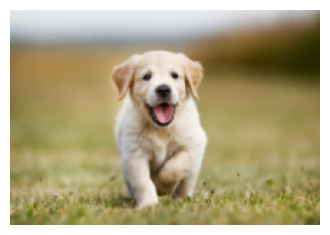

In [5]:
show_img(img2)

## RGB -> Grey

### Basic Python

In [6]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten() # convert the 3 channel matrix into 1D vector
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    #this is the formula to convert rgb into bw equivalent spectrum. got from lect_2
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]  #i, i+n, i+2n is to get the R,G,B values respectively from the flattened vector.
    return res.view(h,w)

In [7]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 1.73 s, sys: 4.46 ms, total: 1.74 s
Wall time: 1.82 s


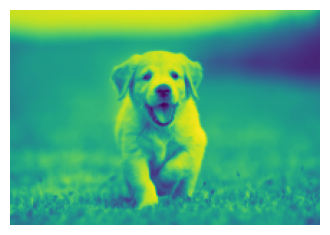

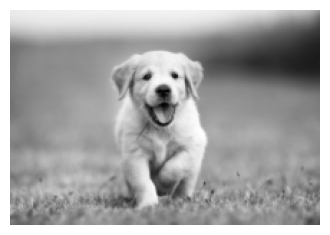

In [8]:
show_img(img_g)
show_img(img_g, cmap='gray')

That took ~2 seconds for a small image. Now we do it using CUDA to speed things up.

### Python Kernel: The following kernel pipeline are tempelates in Python depicting the working of kernels used in CUDA.

In [9]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

A kernel cannot return anything. It can only change contents of things passed to it.

In [10]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [11]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)


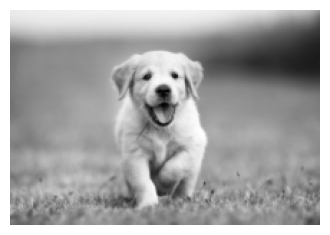

In [12]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

1. **Streaming Multiprocessors (SMs):** In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
2. **Thread Blocks:** A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
3. **Shared Memory:** Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.

- The RTX 3090, based on the Ampere architecture, has 82 SMs.
- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

### Python Block Kernel: The standard way of working with kernels is via blocks. It is shown below using nested loops:

To be more realistic, the cuda threads are run concurrently within thread blocks. So an updated code is presented below to incorporate thread block logic:

In [13]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

In [14]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i<n: out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [15]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

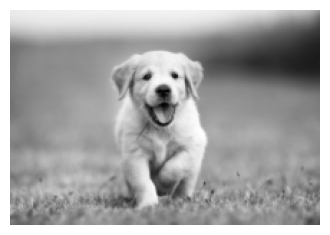

In [16]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

### CUDA Setup

In [17]:
# used in dev mode to instantly stop all execution when any error occurs.
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [18]:
# wurlitzer is a package to help print debug statements while running CUDA in ipynb
%load_ext wurlitzer

In [19]:
#load_inline is a useful pytorch built-in function to get python code from cuda/cpp code.
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [20]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA kernel

Hard limits of CUDA kernel parallelisation
- 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
- 1024 max threads per block (use a multiple of 32)

<img src="attachment:4590626e-3f24-4381-a14b-50162f737579.png" width="500">

How do you write the code below? just give the corresponding python code to ChatGPT and tell it to do it (Just verify the datatypes afterwards):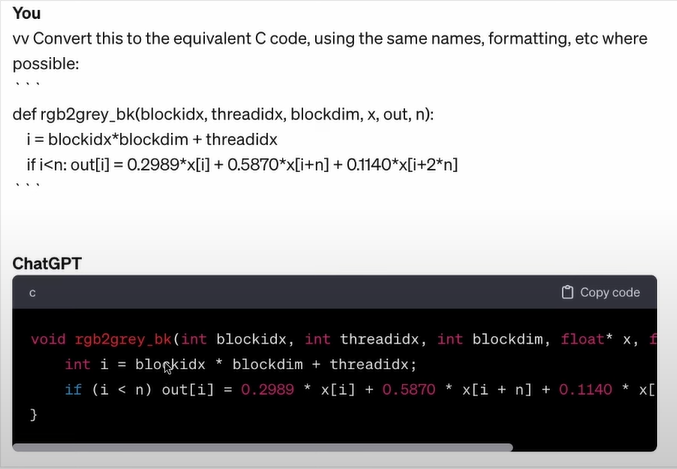

whats with the dunder global below? these are keywords to specify the device from which the function can be called (CPU or GPU) and device on which function can be run (CPU or GPU). __global__ is used when you want to call a function from CPU and run it on GPU.
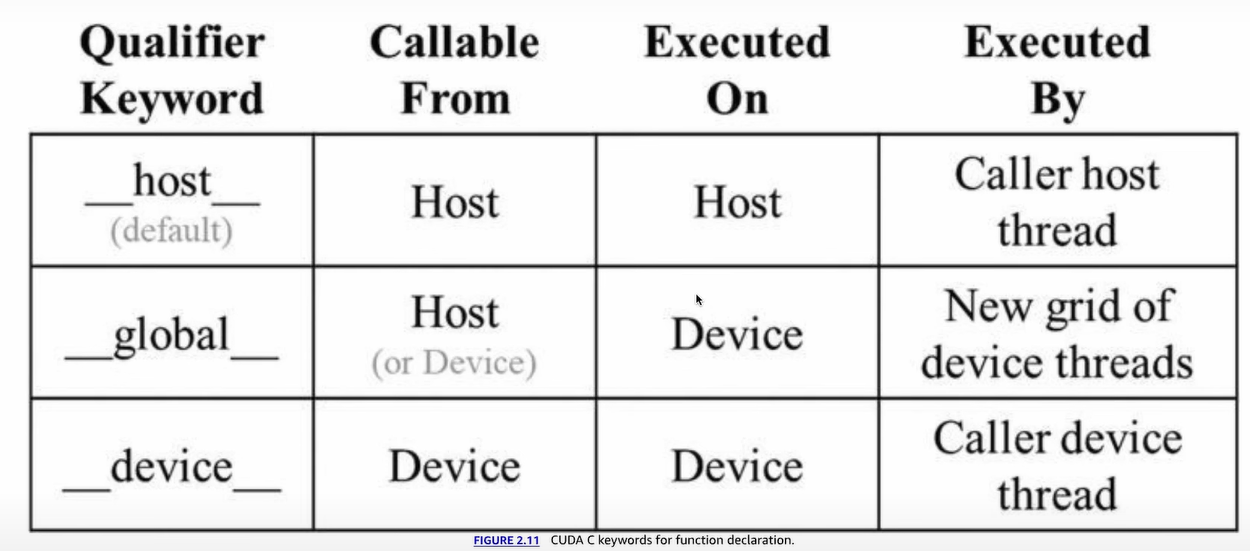

In [21]:
#unsigned char* x of C is similar to uint8 of python
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

// Converts an RGB image tensor into a grayscale image tensor using CUDA parallelism.
torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    // Check if the input tensor is valid and on the correct device (probably on the GPU).
    CHECK_INPUT(input);

    // Extract the height (h) and width (w) of the input image.
    int h = input.size(1);  // Height of the image.
    int w = input.size(2);  // Width of the image.

    // Debugging print statement to display the dimensions of the image.
    printf("h*w: %d*%d\n", h, w);

    // Create an empty tensor to hold the output grayscale image.
    // The dimensions of the grayscale image will be [h, w] and it will have the same
    // properties (e.g., data type, device) as the input tensor.
    auto output = torch::empty({h, w}, input.options());

    // Define the number of threads per block in CUDA.
    // Each thread is responsible for processing one or more pixels of the image.
    int threads = 256;

    // Launch the CUDA kernel to convert the RGB image to grayscale.
    // - `cdiv(w*h, threads)` computes the number of thread blocks needed to cover the entire image.
    //   Each block will have `threads` number of threads, and we need enough blocks to process all pixels.
    // - `input.data_ptr<unsigned char>()` provides access to the raw RGB data of the input tensor.
    // - `output.data_ptr<unsigned char>()` provides access to the memory of the output grayscale image.
    // - `w*h` is the total number of pixels in the image (height * width).
    rgb_to_grayscale_kernel<<<cdiv(w*h, threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);

    // Check if the kernel launch was successful.
    // This macro will catch any CUDA-related errors and help with debugging.
    C10_CUDA_KERNEL_LAUNCH_CHECK();

    // Return the output grayscale image as a PyTorch tensor.
    return output;
}
'''

In [22]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [23]:
# Load the CUDA and C++ source files and compile them into a callable module
# The load_cuda function compiles the provided CUDA (.cu) and C++ (.cpp) files and returns a Python module.
# This module allows calling the CUDA functions from Python, enabling GPU acceleration for specified functions.
#
# Parameters:
# - cuda_src: Path to the CUDA source file (.cu) containing the CUDA kernels (e.g., rgb_to_grayscale).
# - cpp_src: Path to the C++ source file (.cpp) that might include additional necessary functions or setup for CUDA.
# - ['rgb_to_grayscale']: A list of function names (kernels) to be made available in the module.
# - verbose=True: Enables verbose output during the compilation process, helpful for debugging by printing extra details.
#
# The result is a compiled module where the specified functions (in this case, 'rgb_to_grayscale') can be called.
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

# After loading, the 'module' will contain the 'rgb_to_grayscale' function,
# allowing us to call it directly in Python to perform GPU-accelerated operations.


Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.10/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.10/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.10/dist-packages/torch/include

Loading extension module inline_ext...


In [68]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'matmul']

In [25]:
# Ensure the tensor has contiguous memory layout (elements of the tensor are stored in a single, continuous block of memory without gaps)
# and transfer the tensor to the GPU for CUDA operations.
imgc = img.contiguous().cuda()


In [26]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()
h,w = res.shape
h,w,h*w

CPU times: user 3.08 ms, sys: 8 µs, total: 3.09 ms
Wall time: 3.21 ms


(1330, 1920, 2553600)

h*w: 1330*1920


3.21 ms from 1.82 seconds!!

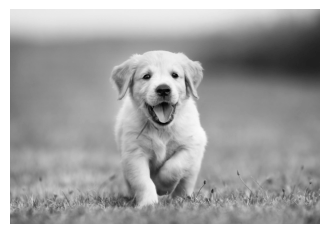

In [27]:
show_img(res, cmap='gray')

## Matmul

### Get data

In [28]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [29]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [30]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [31]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

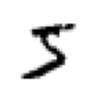

In [32]:
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

In [33]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

### Python matmul

In [34]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [35]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [36]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [37]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [38]:
t1.shape

torch.Size([5, 10])

In [39]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [40]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [41]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [42]:
%time _=matmul(m1, m2)

CPU times: user 876 ms, sys: 5.13 ms, total: 881 ms
Wall time: 891 ms


In [43]:
ar*bc*ac

39200

### 2d Python kernel

In [44]:
from types import SimpleNamespace as ns

In [45]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): f(ns(x=i1,y=i0), ns(x=j1,y=j0), threads, *args)

In [46]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x

    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

In [47]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [48]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

### Vectorization and Broadcasting to make python code faster:

In [49]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [50]:
torch.isclose(t1,matmul(m1, m2)).all()

tensor(True)

In [51]:
%time _=matmul(m1, m2)

CPU times: user 812 µs, sys: 1.1 ms, total: 1.91 ms
Wall time: 1.72 ms


In [52]:
m1 = x_train
tr = matmul(m1, m2)
tr.shape

torch.Size([50000, 10])

In [53]:
%time _=matmul(m1, m2)

CPU times: user 1.57 s, sys: 6.29 ms, total: 1.58 s
Wall time: 1.88 s


In [54]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000

### CUDA matmul

In [55]:
cuda_src = cuda_begin + r'''
// CUDA kernel function for matrix multiplication
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    // Calculate the row index (r) and column index (c) for the output matrix
    // blockIdx and threadIdx are built-in variables that identify the block and thread within a block
    int r = blockIdx.y * blockDim.y + threadIdx.y; // Row index
    int c = blockIdx.x * blockDim.x + threadIdx.x; // Column index

    // Check if the calculated row and column indices are within bounds of the output matrix
    // If either index is out of bounds, exit the kernel early
    if (r >= h || c >= w) return;

    // Initialize the output value for this position in the output matrix
    float o = 0;

    // Perform the dot product for the r-th row of matrix m and the c-th column of matrix n
    // This involves summing up products of corresponding elements
    for (int i = 0; i < k; ++i) {
        o += m[r * k + i] * n[i * w + c]; // Accessing elements in row-major order
    }

    // Store the computed value in the output matrix at the appropriate position
    out[r * w + c] = o;
}

// Wrapper function for matrix multiplication using PyTorch tensors
torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    // Check if input tensors are valid (e.g., not null and on the correct device)
    CHECK_INPUT(m);
    CHECK_INPUT(n);

    // Get dimensions of input matrices
    int h = m.size(0); // Number of rows in matrix m
    int w = n.size(1); // Number of columns in matrix n
    int k = m.size(1); // Number of columns in matrix m (or rows in matrix n)

    // Ensure that the inner dimensions match for valid matrix multiplication
    TORCH_CHECK(k == n.size(0), "Size mismatch!");

    // Create an output tensor initialized to zeros with dimensions [h, w]
    auto output = torch::zeros({h, w}, m.options());

    // Define thread per block dimensions (16x16), which determines how many threads will be used per block.
    // Using a 2D structure allows for natural mapping to two-dimensional data (e.g., matrices).
    // Each thread will correspond to a specific element in the output matrix,
    // facilitating efficient indexing and memory access patterns.
    dim3 tpb(16, 16);

    // Calculate how many blocks are needed based on output dimensions and threads per block.
    // This setup allows for flexible handling of various input sizes while maximizing GPU resource utilization.
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));

    // Launch the CUDA kernel with calculated blocks and threads per block.
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(),   // Pointer to data in tensor m
        n.data_ptr<float>(),   // Pointer to data in tensor n
        output.data_ptr<float>(), // Pointer to data in output tensor
        h,                     // Height (number of rows) of input tensor m
        w,                     // Width (number of columns) of input tensor n
        k                      // Inner dimension size (number of columns in m / rows in n)
    );

    // Check for any errors that occurred during kernel launch or execution.
    C10_CUDA_KERNEL_LAUNCH_CHECK();

    // Return the resulting output tensor after multiplication.
    return output;
}
'''

In [56]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [57]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [58]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [59]:
torch.isclose(tr,module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [60]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 6.42 ms, sys: 0 ns, total: 6.42 ms
Wall time: 5.85 ms


torch.Size([50000, 10])

### Pytorch

In [61]:
torch.isclose(tr,(m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [62]:
%timeit -n 10 _=(m1c@m2c).cpu()

2.08 ms ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Pytorch faster than our CUDA? cz torch efficiently uses the shared memory features provided by CUDA.



You can try making instead of 1D, a 3D RGB to Grayscale converter as an exercise.